In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
harvard = pd.read_csv("../data/cat_df.csv")
harvard = harvard.drop("Unnamed: 0", axis=1)
BB = pd.read_csv("../data/Hot Stuff.csv")
BB["Song"] = [i.lower() for i in BB["Song"]]
BB["Performer"] = [i.lower() for i in BB["Performer"]]

In [3]:
BB_Song = BB.groupby(["Performer", "Song"]).agg({"WeekID": np.min}).reset_index()
BB_Song["WeekID"] = pd.to_datetime(BB_Song["WeekID"])
BB_Song["MonthID"] = [i.year + (i.month - 1)/12 for i in BB_Song["WeekID"]]

In [4]:
harvard.head()

,song,artist,Positive,Negative,Time,Human,Object,Knowledge,Number,Communication,Place,Government,word_count
0,sauce it up,lil uzi vert,2.0,10.0,1.0,5.0,2.0,0.0,13.0,0.0,0.0,0.0,33.0
1,backroad song,granger smith,7.0,0.0,13.0,1.0,7.0,0.0,1.0,10.0,4.0,0.0,43.0
2,feelin' satisfied,boston,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,6.0
3,saturday morning confusion,bobby russell,2.0,9.0,20.0,12.5,7.0,1.0,5.0,1.0,2.0,0.0,59.5
4,country man,luke bryan,1.0,1.0,1.0,5.0,4.0,0.0,4.0,0.0,2.0,0.0,18.0


In [5]:
BB_Song.head()

,Performer,Song,WeekID,MonthID
0,"""groove"" holmes",misty,1966-06-25,1966.416667
1,"""groove"" holmes",what now my love,1966-10-01,1966.750000
2,"""little"" jimmy dickens",may the bird of paradise fly up your nose,1965-10-16,1965.750000
3,"""pookie"" hudson",i know i know,1963-05-25,1963.333333
4,"""weird al"" yankovic",amish paradise,1996-03-30,1996.166667


In [6]:
harvard_BB = pd.DataFrame(harvard.merge(BB_Song, left_on=["song", "artist"], right_on=["Song", "Performer"], how="inner")).reset_index(drop=True)

In [7]:
harvard_BB.shape

(22708, 17)

In [8]:
harvard_BB.head()

,song,artist,Positive,Negative,Time,Human,Object,Knowledge,Number,Communication,Place,Government,word_count,Performer,Song,WeekID,MonthID
0,sauce it up,lil uzi vert,2.0,10.0,1.0,5.0,2.0,0.0,13.0,0.0,0.0,0.0,33.0,lil uzi vert,sauce it up,2017-10-14,2017.750000
1,backroad song,granger smith,7.0,0.0,13.0,1.0,7.0,0.0,1.0,10.0,4.0,0.0,43.0,granger smith,backroad song,2016-01-16,2016.000000
2,feelin' satisfied,boston,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,6.0,boston,feelin' satisfied,1979-03-24,1979.166667
3,saturday morning confusion,bobby russell,2.0,9.0,20.0,12.5,7.0,1.0,5.0,1.0,2.0,0.0,59.5,bobby russell,saturday morning confusion,1971-10-02,1971.750000
4,country man,luke bryan,1.0,1.0,1.0,5.0,4.0,0.0,4.0,0.0,2.0,0.0,18.0,luke bryan,country man,2008-10-11,2008.750000


In [9]:
harvard_BB.loc[1, "WeekID"].month

1

In [10]:
harvard_BB["SemiYearID"] = [int(i.year) if i.month <= 6 else int(i.year) + 0.5 for i in harvard_BB["WeekID"]]

In [11]:
categories = [i for i in harvard.columns.tolist() if i != "song" and i != "artist"]

In [12]:
harvard_BB_SemiYear = pd.DataFrame(harvard_BB.groupby("SemiYearID").sum()[[i for i in harvard.columns.tolist() if i != "song" and i != "artist"]]).reset_index()

In [13]:
for k in categories:
    harvard_BB_SemiYear[k] = [i/j for i, j in zip(harvard_BB_SemiYear[k], harvard_BB_SemiYear["word_count"])]

In [14]:
harvard_BB_SemiYear.head()

,SemiYearID,Positive,Negative,Time,Human,Object,Knowledge,Number,Communication,Place,Government,word_count
0,1958.5,0.190114,0.150462,0.107985,0.151983,0.094297,0.021727,0.165671,0.026725,0.087127,0.003911,1.0
1,1959.0,0.190924,0.105520,0.150901,0.149370,0.129533,0.029164,0.125148,0.016914,0.094174,0.008352,1.0
2,1959.5,0.209711,0.120197,0.102324,0.161901,0.127197,0.025916,0.145964,0.026810,0.071939,0.008043,1.0
3,1960.0,0.216835,0.123437,0.098859,0.134664,0.101651,0.024639,0.175507,0.018206,0.092487,0.013715,1.0
4,1960.5,0.218986,0.115675,0.117821,0.172900,0.087370,0.021459,0.150419,0.016554,0.080421,0.018394,1.0


In [15]:
harvard_BB_SemiYear = harvard_BB_SemiYear.drop("word_count", axis=1)

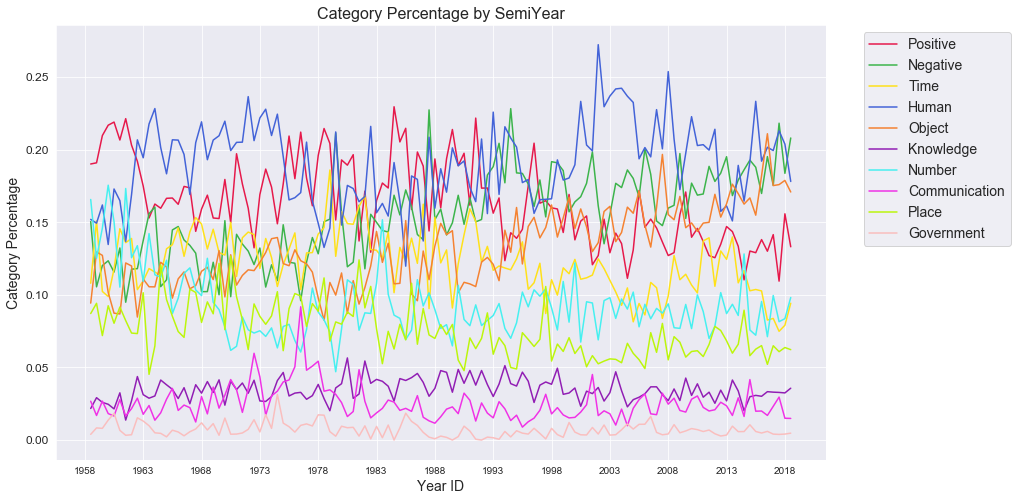

In [16]:
plt.figure(figsize=(13.8, 8))
sns.set_style("darkgrid")
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
for i,k in enumerate(categories):
    if k != "word_count":
        plt.plot(harvard_BB_SemiYear["SemiYearID"],harvard_BB_SemiYear[k], label=k,color=colors[i])
plt.legend(fontsize=14, bbox_to_anchor=(1.04,1))
plt.title("Category Percentage by SemiYear", fontsize=16)
plt.ylabel("Category Percentage", fontsize=14)
plt.xlabel("Year ID", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(list(range(int(min(harvard_BB_SemiYear["SemiYearID"])), int(max(harvard_BB_SemiYear["SemiYearID"])) + 5, 5)))
plt.show()

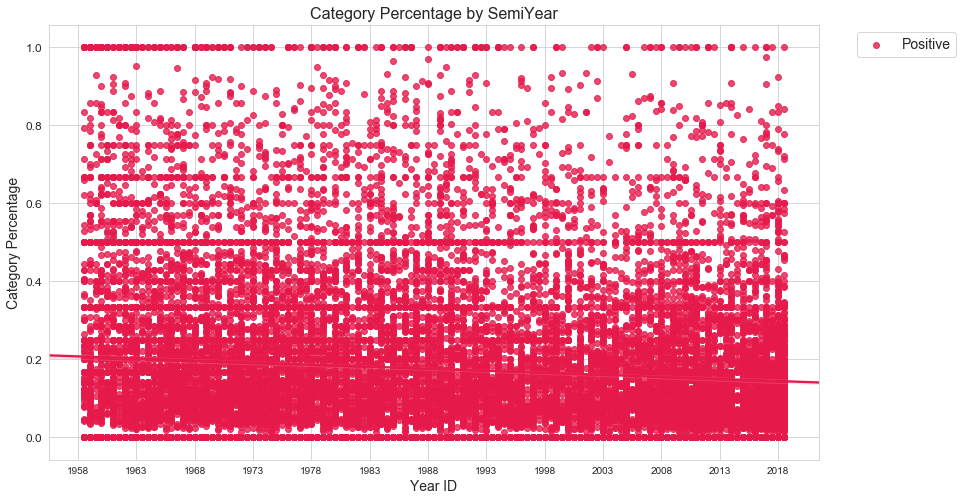

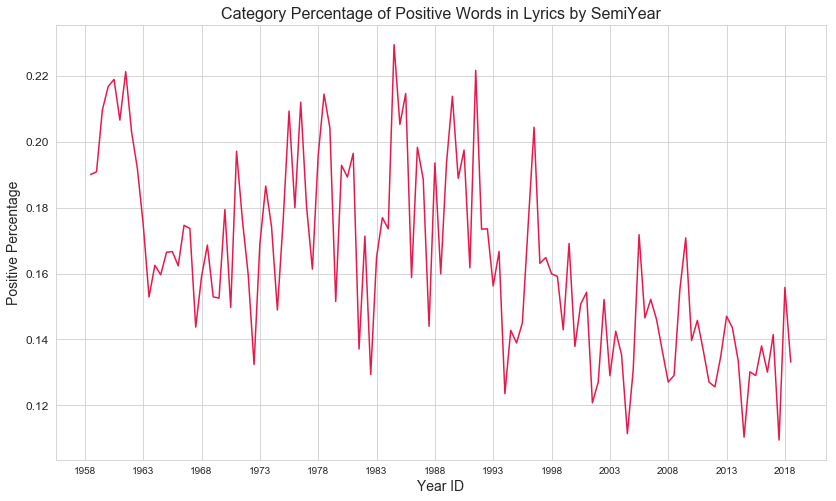

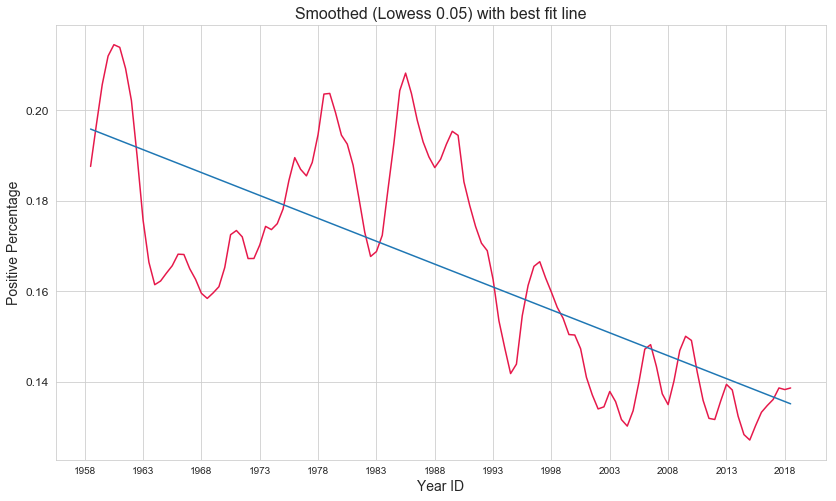

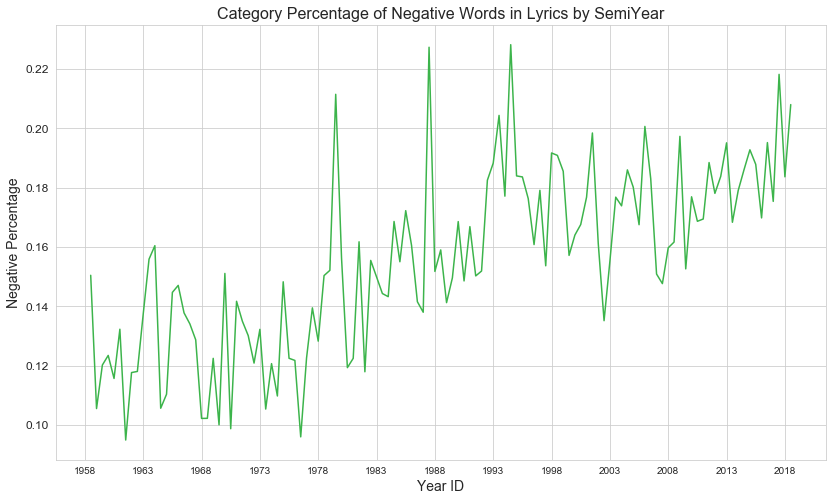

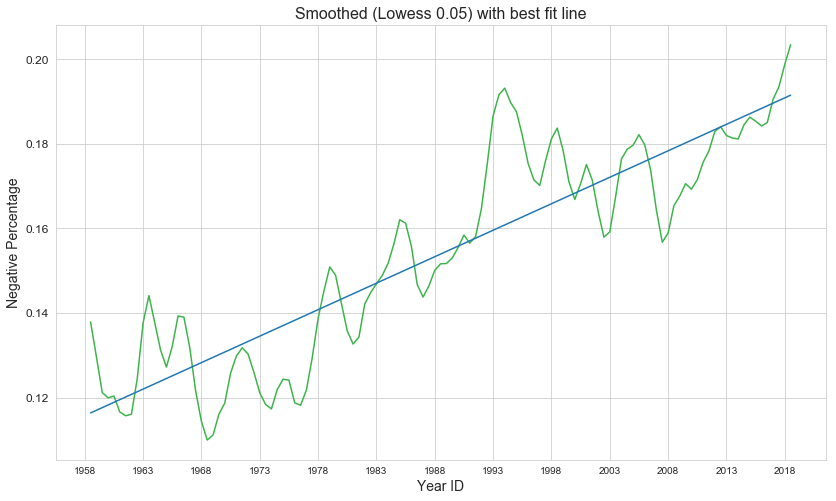

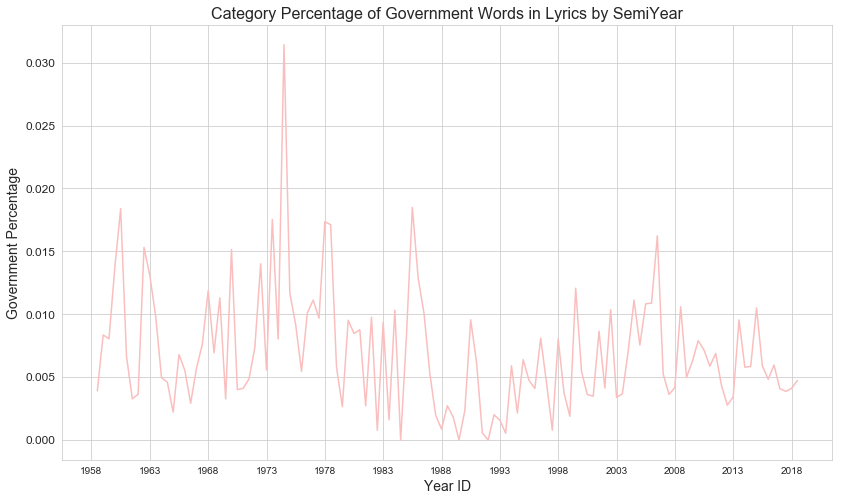

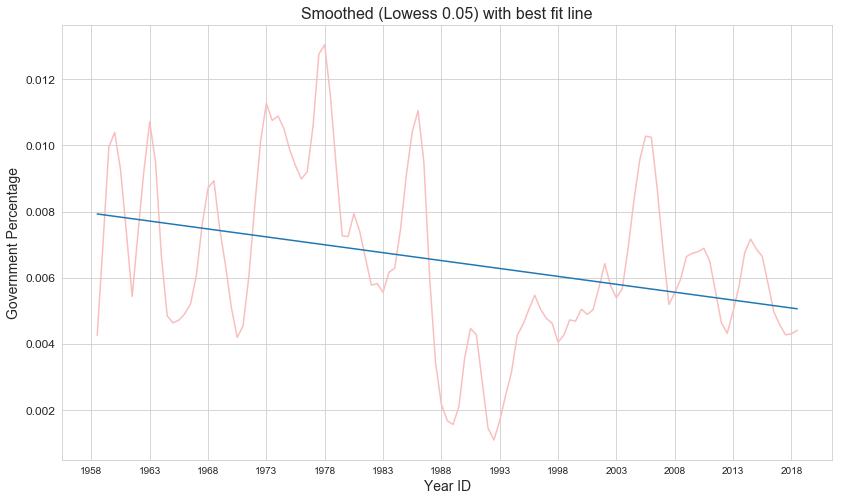

In [17]:
plt.figure(figsize=(13.8, 8))
sns.set_style("whitegrid")
harvard_BB = harvard_BB[harvard_BB["word_count"]>=1]
props = [c/wc for c,wc in zip(harvard_BB["Positive"],harvard_BB["word_count"])]
sns.regplot(data=harvard_BB,x="SemiYearID",y=props, label="Positive",color=colors[0])
plt.legend(fontsize=14, bbox_to_anchor=(1.04,1))
plt.title("Category Percentage by SemiYear", fontsize=16)
plt.ylabel("Category Percentage", fontsize=14)
plt.xlabel("Year ID", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(list(range(int(min(harvard_BB_SemiYear["SemiYearID"])), int(max(harvard_BB_SemiYear["SemiYearID"])) + 5, 5)))
plt.show()

cat = "Positive"
def some_plts(cat):
    plt.figure(figsize=(13.8, 8))
    sns.set_style("whitegrid")
    plt.plot(harvard_BB_SemiYear["SemiYearID"],harvard_BB_SemiYear[cat], label=cat,color=colors[categories.index(cat)])
    plt.title("Category Percentage of {} Words in Lyrics by SemiYear".format(cat), fontsize=16)
    plt.ylabel("{} Percentage".format(cat), fontsize=14)
    plt.xlabel("Year ID", fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(list(range(int(min(harvard_BB_SemiYear["SemiYearID"])), int(max(harvard_BB_SemiYear["SemiYearID"])) + 5, 5)))
    plt.show()

    plt.figure(figsize=(13.8, 8))
    sns.set_style("whitegrid")
    smoothed_perc = lowess(harvard_BB_SemiYear[cat],harvard_BB_SemiYear.SemiYearID,frac=0.05)[:,1]
    plt.plot(harvard_BB_SemiYear["SemiYearID"],smoothed_perc, label=cat,color=colors[categories.index(cat)])
    p = np.poly1d(np.polyfit(harvard_BB_SemiYear["SemiYearID"], smoothed_perc, 1))
    yp = list(map(p,harvard_BB_SemiYear["SemiYearID"]))
    plt.plot(harvard_BB_SemiYear["SemiYearID"], yp)
    #plt.legend(fontsize=14, bbox_to_anchor=(1.04,1))
    plt.title("Smoothed (Lowess 0.05) with best fit line", fontsize=16)
    plt.ylabel("{} Percentage".format(cat), fontsize=14)
    plt.xlabel("Year ID", fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(list(range(int(min(harvard_BB_SemiYear["SemiYearID"])), int(max(harvard_BB_SemiYear["SemiYearID"])) + 5, 5)))
    plt.show()
some_plts("Positive")
some_plts("Negative")
some_plts("Government")

In [91]:
p = np.poly1d(np.polyfit(harvard_BB_SemiYear["SemiYearID"], smoothed_perc, 1))
yp = list(map(p,harvard_BB_SemiYear["SemiYearID"]))

In [18]:
Inflation = pd.read_csv("../data/Econ/Inflation, consumer prices for the United States.csv")
GDP = pd.read_csv("../data/Econ/Real Gross Domestic Product.csv")
Income = pd.read_csv("../data/Econ/Real Disposable Personal Income.csv")
Unemployment = pd.read_csv("../data/unemp.csv")
Inflation.columsn = ["DATE", "Econ"]
GDP.columns = ["DATE", "Econ"]
Income.columns = ["DATE", "Econ"]

c:\users\craut\miniconda3\envs\music_econ\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


In [19]:
Unemployment["FirstHalf"] = 0
Unemployment["SecondHalf"] = 0
for i in range(Unemployment.shape[0]):
    Unemployment.loc[i, "FirstHalf"] = np.mean(Unemployment.loc[i, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']].values.tolist())
    Unemployment.loc[i, "SecondHalf"] = np.mean(Unemployment.loc[i, ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].values.tolist())

In [20]:
results = list()
time = list()
for i in range(Unemployment.shape[0]):
    results.append(Unemployment.loc[i, "FirstHalf"])
    time.append(int(Unemployment.loc[i, "Year"]))
    results.append(Unemployment.loc[i, "SecondHalf"])
    time.append(int(Unemployment.loc[i, "Year"]) + 0.5)

In [21]:
Unemployment = pd.DataFrame()
Unemployment["SemiYearID"] = time
Unemployment["Econ"] = results

In [22]:
Inflation["DATE"] = pd.to_datetime(Inflation["DATE"])
GDP["DATE"] = pd.to_datetime(GDP["DATE"])
Income["DATE"] = pd.to_datetime(Income["DATE"])
GDP["MonthID"] = [i.year + (i.month - 1)/12 for i in GDP["DATE"]]
Income["MonthID"] = [i.year + (i.month - 1)/12 for i in Income["DATE"]]
GDP["SemiYearID"] = [int(i.year) if i.month <= 6 else int(i.year) + 0.5 for i in GDP["DATE"]]
Income["SemiYearID"] = [int(i.year) if i.month <= 6 else int(i.year) + 0.5 for i in Income["DATE"]]
Inflation["SemiYearID"] = [int(i.year) if i.month <= 6 else int(i.year) + 0.5 for i in Inflation["DATE"]]

In [23]:
GDP_semiYear = GDP.groupby("SemiYearID").mean().reset_index()
Income_semiYear = Income.groupby("SemiYearID").mean().reset_index()
Inflation_semiYear = Inflation.groupby("SemiYearID").mean().reset_index()

In [24]:
Inflation_semiYear.columns = ["SemiYearID", "Econ"]

In [25]:
ds = [GDP_semiYear, Income_semiYear, Inflation_semiYear, Unemployment]
ds_names = ["GDP", "Income", "Inflation", "Unemployment"]

AttributeError: 'list' object has no attribute 'shape'

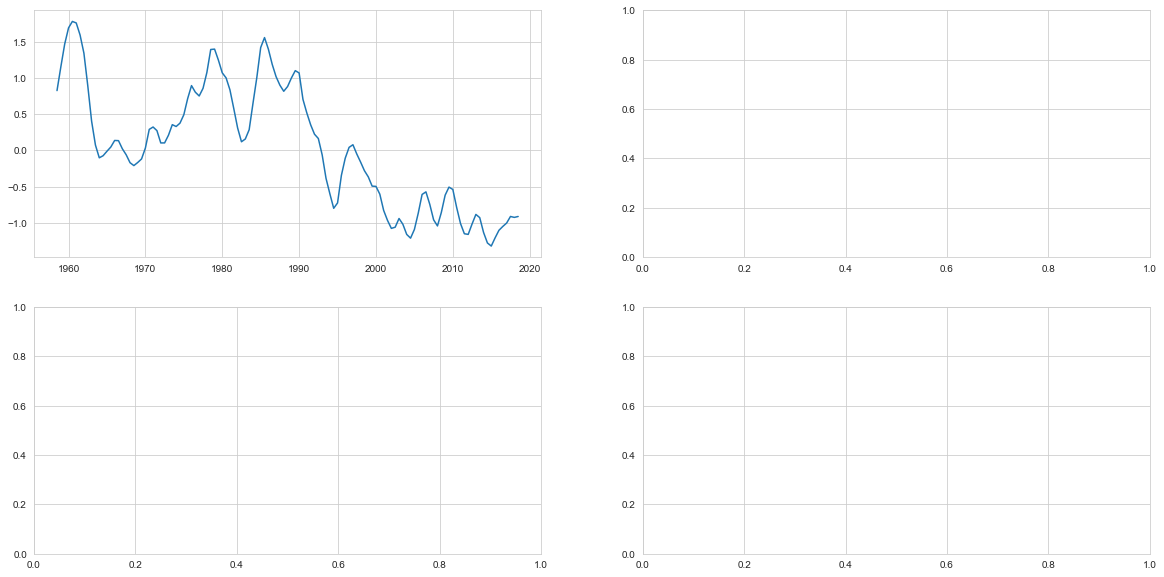

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_style("whitegrid")
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    cat = "Positive"
    data = harvard_BB_SemiYear[cat]
    econ = ds[i]["Econ"]
    x1,y1 = harvard_BB_SemiYear["SemiYearID"], [(i - np.mean(data)) / np.std(data) for i in data]
    y1s = lowess(y1,x1,frac=0.05)[:,1]
    plt.plot(x1,y1s, label=cat)
    x2,y2 = [i+0.5 for i in ds[i]["SemiYearID"]], [(i - np.mean(econ)) / np.std(econ) for i in econ]
    print(y2.shape)
    y2s = lowess(y2,x2,frac=0.05)[:,1]
    print(y2s.shape)
    plt.plot(x2,y2s, label=ds_names[i])
    plt.legend(fontsize=14)
    plt.xlabel("SemiYearID", fontsize=14)
    plt.ylabel("Standarized Data", fontsize=14)


ValueError: x and y must have same first dimension, but have shapes (124,) and (122,)

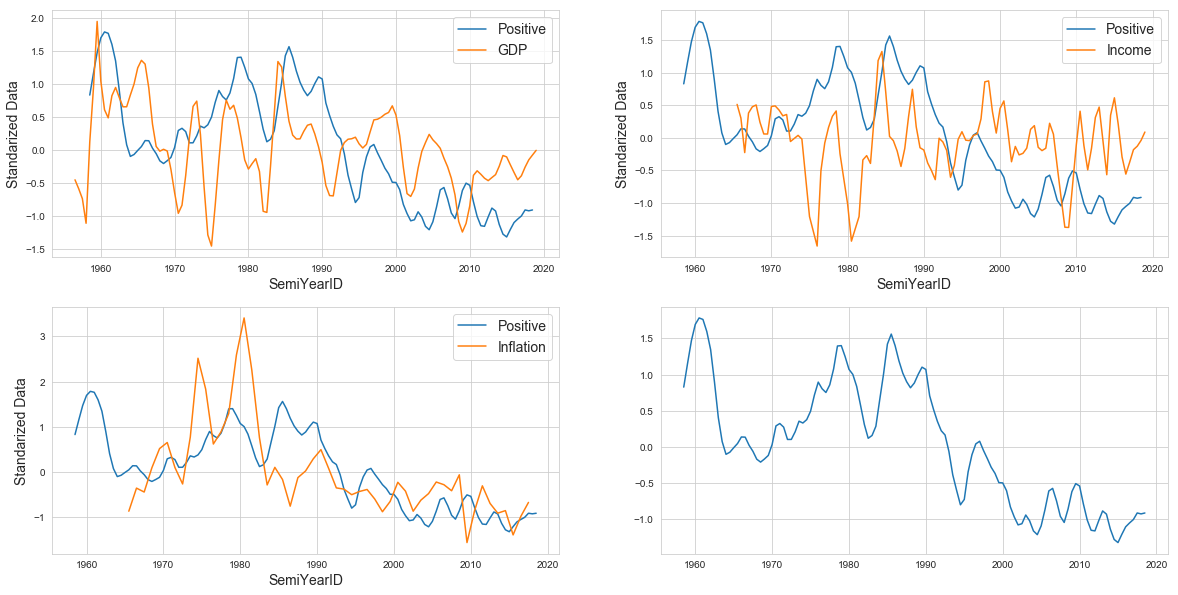

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_style("whitegrid")
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    cat = "Positive"
    data = harvard_BB_SemiYear[cat]
    econ = ds[i]["Econ"]
    x1,y1 = harvard_BB_SemiYear["SemiYearID"], [(i - np.mean(data)) / np.std(data) for i in data]
    y1s = lowess(y1,x1,frac=0.05)[:,1]
    plt.plot(x1,y1s, label=cat)
    x2,y2 = [i+0.5 for i in ds[i]["SemiYearID"]], [(i - np.mean(econ)) / np.std(econ) for i in econ]
    y2s = lowess(y2,x2,frac=0.05)[:,1]
    plt.plot(x2,y2s, label=ds_names[i])
    plt.legend(fontsize=14)
    plt.xlabel("SemiYearID", fontsize=14)
    plt.ylabel("Standarized Data", fontsize=14)


In [28]:
plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")
data = harvard_BB_SemiYear["Positive"]
# econ = Inflation_semiYear["FPCPITOTLZGUSA"]
# econ = Income_semiYear["A067RL1Q156SBEA"]
econ = GDP_semiYear["A191RL1Q225SBEA"]
plt.plot(harvard_BB_SemiYear["SemiYearID"], [(i - np.mean(data)) / np.std(data) for i in data], label="Negative")
plt.plot([i+0.5 for i in GDP_semiYear["SemiYearID"]], [(i - np.mean(econ)) / np.std(econ) for i in econ], label="Inflation")
plt.legend(fontsize=14)
plt.xlabel("SemiYearID")

KeyError: 'A191RL1Q225SBEA'

<Figure size 1440x720 with 0 Axes>

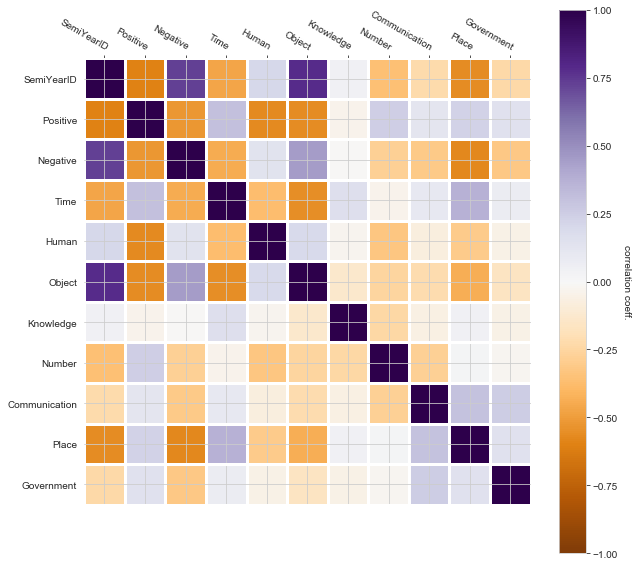

In [35]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
corr_matrix = np.corrcoef(np.transpose(harvard_BB_SemiYear.to_numpy()))
im, _ = heatmap(corr_matrix, list(harvard_BB_SemiYear.columns), list(harvard_BB_SemiYear.columns), ax=ax,
                cmap="PuOr", vmin=-1, vmax=1,
                cbarlabel="correlation coeff.")

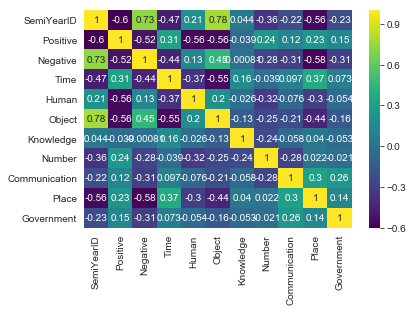

In [41]:
sns.heatmap(harvard_BB_SemiYear.corr(),annot=True,cmap="viridis")